In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn import svm

In [77]:
param_data = pd.read_csv("../data/interim/interim_data.csv")
param_data.head()

,ID,StudySample,LaserPowerHatch,LaserSpeedHatch,HatchSpacing,LaserPowerContour,Porosity,LayerHeight,EnergyDensityCalculated,Machine,Powder,MicroCTScan,HatchOffsetFromCountour
0,1,Plessis_1-1,280.0,1200.0,0.14,150.0,0.013,0.03,55.555556,EOS M290,EOS-supplied Ti6Al4V ELI,NaN,0.015
1,2,Plessis_1-2,252.0,1200.0,0.14,135.0,0.008,0.03,50.000000,EOS M290,EOS-supplied Ti6Al4V ELI,NaN,0.015
2,3,Plessis_1-3,224.0,1200.0,0.14,120.0,0.007,0.03,44.444444,EOS M290,EOS-supplied Ti6Al4V ELI,NaN,0.015
3,4,Plessis_1-4,197.0,1200.0,0.14,105.0,0.045,0.03,39.087302,EOS M290,EOS-supplied Ti6Al4V ELI,NaN,0.015
4,5,Plessis_1-5,308.0,1200.0,0.14,165.0,0.017,0.03,61.111111,EOS M290,EOS-supplied Ti6Al4V ELI,NaN,0.015


In [78]:
drop_cols = ["ID","StudySample","HatchOffsetFromCountour", "LaserPowerContour","HatchSpacing", "MicroCTScan", "Machine", "Powder","LayerHeight"]
for col in drop_cols:
    try:
        # dropping unnecessary columns, put into error catching so the program doesn't quit if one of these are already dropped or doesnt exist
        param_data = param_data.drop(col, axis=1)
        print(f"dropped {col}")
    except:
        print(f"already dropped {col}")
try:
    # dropping outliers
    param_data = param_data.drop([10,14,9], axis=0).reset_index(drop=True)
except:
    print('already dropped outliers')

# reorder to put label (Porosity) to make label selection easy (can index last column with [:,-1])
param_data = param_data[["LaserPowerHatch","LaserSpeedHatch","EnergyDensityCalculated","Porosity"]]

dropped ID
dropped StudySample
dropped HatchOffsetFromCountour
dropped LaserPowerContour
dropped HatchSpacing
dropped MicroCTScan
dropped Machine
dropped Powder
dropped LayerHeight


In [79]:
# test train split, random sampling, train/test exports - can be left alone
tt_split = .25
pct = 1 - tt_split
seed=100

train_data = param_data.sample(frac=pct, random_state=seed).reset_index(drop=True)
test_data = param_data.drop(train_data.index).sample(frac=1, random_state=seed).reset_index(drop=True)

In [128]:
def transform(train_data, test_data, scale_X, scale_y):
    train_vals = train_data.values
    test_vals = test_data.values

    scale_X.fit(train_vals[:,:-2])
    scale_y.fit(train_vals[:,-1].reshape(-1, 1))

    X_train = scale_X.transform(train_vals[:,:-2])
    y_train = scale_y.transform(train_vals[:,-1].reshape(-1, 1))

    X_test = scale_X.transform(test_vals[:,:-2])
    y_test = scale_y.transform(test_vals[:,-1].reshape(-1, 1))

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = transform(train_data, test_data, MinMaxScaler(), StandardScaler())

In [129]:
svr = svm.SVR(kernel='poly', degree=2)
svr.fit(X_train, y_train.ravel())

print('svr score:', svr.score(X_test,y_test))

svr score: 0.965913596731798


In [120]:
x = scale_X.transform(np.linspace(20,100, 100).reshape(-1,1))
y = svr.predict(x)
y = scale_y.inverse_transform(y)

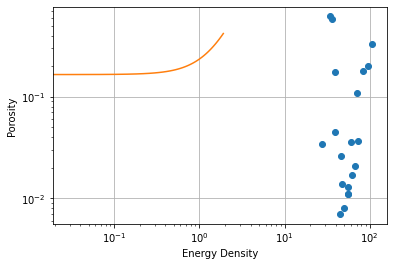

In [121]:
plt.loglog(param_data.EnergyDensityCalculated, param_data.Porosity, 'o')
plt.plot(x,y)
plt.grid()
plt.ylabel('Porosity')
plt.xlabel('Energy Density')
plt.show()

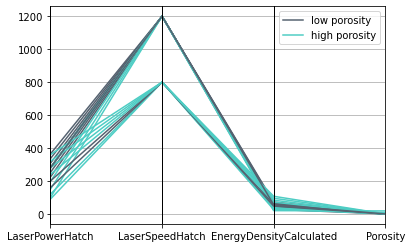

In [12]:
cols = ['LaserPowerHatch', 'LaserSpeedHatch', 'EnergyDensityCalculated', 'Porosity']
param_data['level']  = pd.qcut(param_data.Porosity, q=[0, 0.5, 1.0], labels =['low porosity','high porosity'])
pd.plotting.parallel_coordinates(param_data, class_column='level', cols=cols, color=('#556270', '#4ECDC4', '#C7F464'))
plt.show()

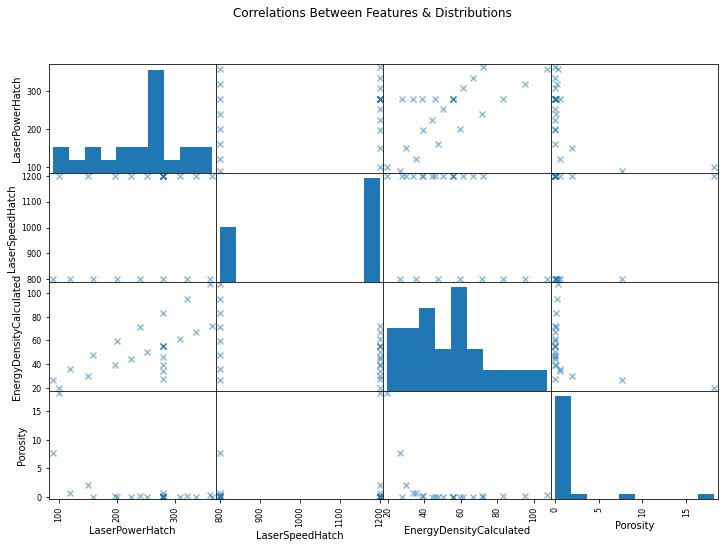

In [29]:
pd.plotting.scatter_matrix(param_data[cols], marker='x',figsize=(12,8))
plt.suptitle('Correlations Between Features & Distributions')
plt.show()